## TO-DO
- Implement object detection
- Evaluation (metrics)

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
import matplotlib.pyplot as plt

from utils.loader import DataLoader
from models.effnet_encoder import EffnetEncoder
from models.mtl_framework import MTLFramework
from utils import tools, config

In [2]:
# Set configs
batch_size = 16
num_train, num_val, num_test = config.config['num_train'], config.config['num_val'], config.config['num_test']
img_height, img_width, channels = config.config['input_shape']

In [3]:
# Load our data pipeline
loader = DataLoader(batch_size)
img_ds = loader.get_image_ds().repeat()
masks_ds = loader.get_mask_ds().repeat()
label_ds = loader.get_binary_ds().repeat()
bbox_ds = loader.get_bboxes_ds().repeat()

Plot some examples (Ignore if training)

In [4]:
# Make some examples
examples = tf.data.Dataset.zip((img_ds, masks_ds, bbox_ds)).as_numpy_iterator()
display_list = next(examples)

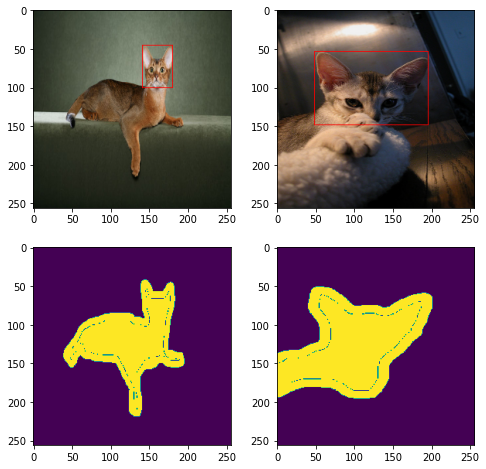

In [13]:
# View some examples
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    box_img = tf.image.draw_bounding_boxes(tf.expand_dims(display_list[0][i,...], 0), tools.fix_bbox(display_list[2][i]).reshape([1,1,4])/256, np.array([[255, 0, 0]]))
    ax1[i].imshow(tf.keras.utils.array_to_img(tf.squeeze(box_img)))
    ax2[i].imshow((display_list[1][i,...]))

Build our MTL

In [6]:
# Get encoder
base_model_name = 'B0'
encoder = EffnetEncoder(base_model_name, (img_height, img_width, channels)).build_encoder(trainable=False)


In [ ]:
encoder.summary()

In [7]:
# Use our MTL framework to build a model
mtl_builder = MTLFramework(encoder, (img_height, img_width, channels))
mtl_builder.add_segmentation_head()
mtl_builder.add_binary_classification_head(base_model_name, trainable=False)
model = mtl_builder.build_mtl_model()

In [ ]:
model.summary()

Train model

In [8]:
def generator_img():
    a = img_ds.as_numpy_iterator()
    b = masks_ds.as_numpy_iterator()
    c = label_ds.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        
        # Regularisation and shuffling
        X, Y1, Y2 = tools.get_randomised_data(X, Y1, Y2)
        X, Y1 = tools.data_augmentation(X, Y1)
        
        yield X, (Y1, Y2)

In [9]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss={'segnet_out' : tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    'bin_class_out' : tf.keras.losses.BinaryCrossentropy()},
              metrics=['accuracy'])

In [6]:
# single head
def generator_img():
    a = img_ds.as_numpy_iterator()
    b = masks_ds.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y = b.next()
        
        # Regularisation and shuffling
        X, Y = get_randomised_data(X, Y)
        X, Y = tools.data_augmentation(X, Y)
        
        yield X, Y
        
def get_randomised_data(x_data: np.array, y_data_1: np.array) -> tuple[np.array]:
    ''' Performs consistent shuffling on input arrays '''
    dataset_size = len(x_data)
    dataset_indices = list(range(dataset_size))

    train_indices = random.sample(dataset_indices, dataset_size)

    x_train = x_data[train_indices, ...]
    y_1_train = y_data_1[train_indices, ...]

    return (x_train, y_1_train)

In [7]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(generator_img(), epochs=10, steps_per_epoch=num_train//batch_size)

Test out model

In [14]:
b = generator_img()
a = next(b)
i = 0

In [18]:
def show_seg_pred(img: np.array, mask_truth: np.array, mask_pred: np.array):
    ''' Show segmentation prediction '''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,12))
    seg_max = tf.where(mask_pred > 0, 1, 0)
    ax1.imshow(tf.keras.utils.array_to_img(tf.squeeze(img)))
    ax2.imshow(tf.keras.utils.array_to_img(mask_truth))
    ax3.imshow(tf.keras.utils.array_to_img(seg_max[0]))

In [ ]:
seg_pred, bin_pred = model.predict(a[0][i][tf.newaxis,...])
tools.show_seg_pred(a[0][i,...], a[1][0][i,...], seg_pred)
print(f'Dog: {1-bin_pred[0]},   Cat: {bin_pred[0]}') # 0 is dog, 1 is cat
i += 1